In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path 


#creates an ORF object, 
#split the AA sequence if '*' and reconstruct the stop codon if it was there in the first place
def split(sequence):
    """
    splits an amino acid sequence at stop codons, outputs split protein sequences
    """
    if not sequence:
        return []
    
    split = sequence.split('*')
    split_wise = [seq + '*' for seq in split[:-1]]
    
    # Check if the last character of orfs is '*'
    if sequence[-1] == '*':
        split_wise.append(split[-1] + '*')
    else:
        split_wise.append(split[-1])
        
    return split_wise

def create_proteins(translated_seq, features = True):
    """
    Takes as input an amino acid sequence, splits it with the split function,
    then starts proteins at plausible initiation sites (ATT, ATG, ATA) in split sequences,
    then outputs the final list of all proteins that came from the initial amino acid sequence.
    """
    min_len = 0 
    final_prots = []
    compteur_RF = 0  # RF counter not as meaningful here but kept for structure

    RF_pos = 0
    for segment in split(translated_seq):  # split on '*'
        longest_prot = 0

        k = 0
        while k < len(segment):
            protein = ''

            if segment[k] == 'M' or segment[k] == 'B': # B is the 
                protein = segment[k:]

                if protein[0] == 'B':
                    protein = 'M' + protein[1:] 

                if protein.endswith('*'):
                    protein = protein[:-1]

                if len(protein) > min_len:
                    protein = protein.replace('B', 'I') # B - ATT can initiate but if not initiating, it is read as I

                    if longest_prot == 0: # only adds the protein from the upstream most initiation codon
                        final_prots.append(protein)
                        longest_prot += 1
                        
            k += 1
        RF_pos += len(segment)

    return final_prots

def violin_plot(feature_values, mtaltco1_length):
    
    df = pd.DataFrame({'lengths': feature_values})

    plt.figure(figsize=(6, 5))
    
    sns.violinplot(
        y='lengths',
        data=df,
        inner=None,
        linewidth=1.2,
        width= 1,
        color = (1.0, 0.4, 0.4, 0.5) 
    )

    # jitter for visibility
    x_jitter = np.random.normal(loc=0, scale=0.05, size=len(df))
    plt.scatter(
        x_jitter,
        df['lengths'],
        color='black',
        alpha=0.4,
        s=1
    )

    # MTALTCO1 @ 259 amino acids
    plt.axhline(mtaltco1_length, color='black', linestyle='--', linewidth=1,
                label='MTALTCO1')
    plt.ylabel('Length (Amino Acids)', fontsize=20)
    plt.legend()
    plt.xticks([])  # No x-axis ticks
    plt.title('Length Distribution of 2000 Generated Proteins')
    plt.tight_layout()
    plt.show()

# Import degenerate sequences 

In [25]:
file_path = "../data/length_DSS.fasta"

length_DSS = {}
with open(file_path, "r") as f:
    key = None
    value = []
    for line in f:
        line = line.strip()
        if line.startswith(">"): # remove ">" 
            if key is not None:
                length_DSS[key] = ''.join(value)
            key = line[1:].strip()  
            value = []
        else:
            value.append(line)
    if key is not None:
        length_DSS[key] = ''.join(value)

# Split into ORFs

In [26]:
#create a dictionary of protein lengths
proteins_features = []

for key, value in length_DSS.items():
   proteins_features.extend(create_proteins(value)) 
  
protein_info_features = {}
for prot in proteins_features:
    protein_info_features[prot] = len(prot)

# Plot with MTALTCO1

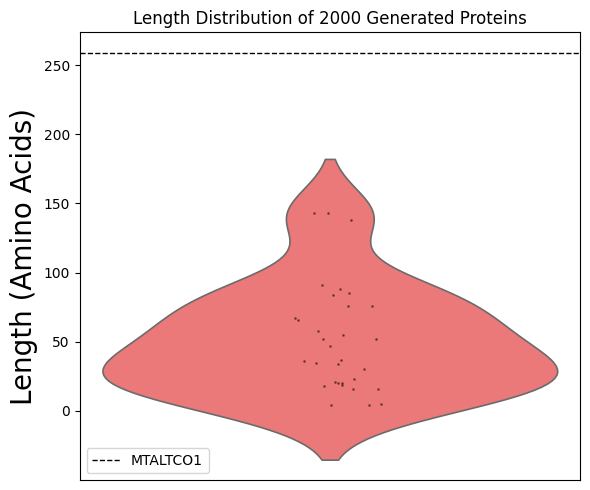

In [27]:
lengths = [value for key,value in protein_info_features.items()]
violin_plot(lengths, 259)